In [ ]:
!pip install pandas transformers torch scikit-learn matplotlib nltk

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder

pd.set_option('display.max_colwidth', 150)

/home/ricardo/Mestrado/CienciaDados/Trabalho1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Verifica se tem GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
df = pd.read_csv('./data/ocorrencias-400.csv')
df.shape[0]
#df.head()

382175

In [5]:
# Cortar para 30000 como teste
df = df.head(30000)
df.shape[0]

30000

In [ ]:
#Explorar o dataset
print("Informações do dataset:")
print(df.info())
print("\nValores ausentes por coluna:")
print(df.isnull().sum())
print("\nNúmero de linhas duplicadas:")
print(df.duplicated().sum())
#print("\nTotal dos dados:")
#print(df.head())

In [4]:
#SELEÇÃO DOS DADOS

#Exclusão de colunas com muitos valores nulos e que não interessam ao estudo
df = df.drop(columns=['GENERO_LGBT'])
df = df.drop(columns=['TIPO_LOGRADOURO'])
df = df.drop(columns=['LATITUDE'])
df = df.drop(columns=['LONGITUDE'])

#Exclusão de linhas com valores nulos na coluna NOME_COR
df = df[df['NOME_COR'].notnull()]

In [5]:
#LIMPEZA E TRATAMENTO DE DADOS

#Remover duplicidades
df = df.drop_duplicates()

#Remover linhas com a coluna SEXO vazia
#df = df.dropna(subset=['SEXO'])

#Preencher sexo vazio com NAO_IDENTIFICADO
df['SEXO'] = df['SEXO'].fillna('NAO_IDENTIFICADO')

#Preencher os bairros vazios com o nome desconhecido
df['BAIRRO'] = df['BAIRRO'].fillna('Desconhecido')

#Preencher idades vazias com a média das idades
df['NUMR_IDADE_ESTIMADA'] = df['NUMR_IDADE_ESTIMADA'].fillna(df['NUMR_IDADE_ESTIMADA'].mean())

In [ ]:
# VERIFICAÇÃO DE DADOS CATEGORICOS
for col in ['NATUREZA_OCORRENCIA', 'FORMA', 'MUNICIPIO', 'BAIRRO', 'NOME_MEIO_EMPREGADO', 'SEXO', 'NOME_COR']:
    print(f"Valores únicos em {col}:")
    print(df[col].value_counts())
    print("\n")


In [ ]:
Q1 = df['NUMR_IDADE_ESTIMADA'].quantile(0.25)
Q3 = df['NUMR_IDADE_ESTIMADA'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['NUMR_IDADE_ESTIMADA'] < Q1 - 1.5 * IQR) | (df['NUMR_IDADE_ESTIMADA'] > Q3 + 1.5 * IQR)]
print("Outliers em NUMR_IDADE_ESTIMADA:")
print(outliers[['NUMR_IDADE_ESTIMADA']])

#Grafico de Boxplot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Definir tamanho da figura
plt.boxplot(df['NUMR_IDADE_ESTIMADA'].dropna(), vert=True)  # Remover NaN, se houver
plt.title('Boxplot de Idades Estimadas')
plt.ylabel('Idade')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [6]:
#VERIFICAÇÃO DE DADOS COLUNAS NUMERICAS
print("Idades fora do intervalo esperado:")
idd_errada = df[(df['NUMR_IDADE_ESTIMADA'] < 0) | (df['NUMR_IDADE_ESTIMADA'] > 100)]
idd_errada.shape[0]

# Remover linhas onde NUMR_IDADE_ESTIMADA está fora de 0 e 100 (inclusive)
df = df[(df['NUMR_IDADE_ESTIMADA'] >= 0) & (df['NUMR_IDADE_ESTIMADA'] <= 100)]

Idades fora do intervalo esperado:


In [7]:
#VERIFICACAO DA NARRATIVA
df['NARRATIVA'] = df['NARRATIVA'].str.strip()
df['NARRATIVA'] = df['NARRATIVA'].fillna('')
print("Narrativas vazias ou muito curtas:")
narr_errada = df[df['NARRATIVA'].str.len() < 50]
#print(narr_errada)
narr_errada.shape[0]

# Remover linhas com narrativa inválida
narr_errada_mask = df['NARRATIVA'].str.len() < 50
df = df[~narr_errada_mask]

Narrativas vazias ou muito curtas:


In [ ]:
#VERIFICAÇÃO DAS FRASES MAIS COMUNS PARA LIMPEZA DAS NARRATIVAS

import pandas as pd
from collections import Counter
import re
from nltk import ngrams
from nltk.tokenize import word_tokenize
import nltk

# Baixar recursos do NLTK (execute apenas uma vez, se necessário)
nltk.download('punkt')

# Função para limpar e tokenizar texto
def preparar_texto(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return ''
    # Converter para minúsculas e remover espaços extras
    texto = texto.lower().strip()
    texto = re.sub(r'\s+', ' ', texto)
    return texto

# Aplicar limpeza inicial na coluna NARRATIVA
df['NARRATIVA_CLEAN'] = df['NARRATIVA'].apply(preparar_texto)

# 1. Extrair as primeiras N palavras ou caracteres de cada narrativa
def extrair_inicio(texto, max_chars=100, max_words=10):
    if not texto:
        return ''
    # Tokenizar em palavras
    palavras = word_tokenize(texto)
    # Pegar até max_words palavras ou max_chars caracteres
    inicio = ' '.join(palavras[:min(max_words, len(palavras))])
    if len(inicio) > max_chars:
        inicio = inicio[:max_chars].rsplit(' ', 1)[0]  # Cortar no último espaço antes de max_chars
    return inicio

# Criar coluna com o início das narrativas
df['INICIO_NARRATIVA'] = df['NARRATIVA_CLEAN'].apply(extrair_inicio)

# 2. Contar prefixos comuns (frases iniciais exatas)
prefixos_comuns = Counter(df['INICIO_NARRATIVA'].str.strip())
prefixos_comuns = {k: v for k, v in prefixos_comuns.items() if k and v > 1}  # Ignorar vazios e únicos

# 3. Contar n-grams para identificar padrões menores
def extrair_ngrams(texto, n=5):
    if not texto:
        return []
    palavras = word_tokenize(texto)
    return [' '.join(gram) for gram in ngrams(palavras, n) if len(palavras) >= n]

# Coletar todos os 5-grams das narrativas
todos_ngrams = []
for texto in df['NARRATIVA_CLEAN']:
    todos_ngrams.extend(extrair_ngrams(texto, n=5))

# Contar frequência dos n-grams
ngrams_comuns = Counter(todos_ngrams)
ngrams_comuns = {k: v for k, v in ngrams_comuns.items() if v > 1}  # Ignorar únicos

# 4. Exibir resultados
print("=== Frases Iniciais Comuns (Prefixos) ===")
for prefixo, contagem in sorted(prefixos_comuns.items(), key=lambda x: x[1], reverse=True)[:50]:
    print(f"Frase: '{prefixo}' | Frequência: {contagem}")

print("\n=== N-grams Comuns (5 palavras) ===")
for ngram, contagem in sorted(ngrams_comuns.items(), key=lambda x: x[1], reverse=True)[:50]:
    print(f"N-gram: '{ngram}' | Frequência: {contagem}")

# 5. Mostrar exemplos de narrativas para cada prefixo comum
#print("\n=== Exemplos de Narrativas por Prefixo Comum ===")
#top_prefixos = sorted(prefixos_comuns.items(), key=lambda x: x[1], reverse=True)[:5]
#for prefixo, _ in top_prefixos:
#    print(f"\nPrefixo: '{prefixo}'")
#    exemplos = df[df['INICIO_NARRATIVA'] == prefixo][['NARRATIVA']].head(3).to_string(index=True)
#    print(exemplos)

In [ ]:
#LIMPEZA DAS NARRATIVAS

# Função para limpar narrativa usando os ngrams_comuns e prefixos_comuns calculados anteriormente
def limpar_texto(texto):
    # Converter para string, caso não seja
    texto = str(texto)
    # Transformar para minúsculo
    texto = texto.lower()
    # Remover padrões repetitivos (prefixos e n-grams)
    # Extrair apenas as chaves (padrões) dos dicionários
    padroes = list(prefixos_comuns.keys()) + list(ngrams_comuns.keys())
    for padrao in padroes:
        # Escapar o padrão para regex
        padrao_escaped = re.escape(padrao)
        # Remover padrão se estiver no início
        texto = re.sub(r'^' + padrao_escaped + r'\b.*?\b', '', texto, flags=re.IGNORECASE)
        # Remover padrão em qualquer parte do texto
        texto = re.sub(r'\b' + padrao_escaped + r'\b', '', texto, flags=re.IGNORECASE)
    # Remover espaços extras (início, fim e múltiplos)
    texto = re.sub(r'\s+', ' ', texto.strip())
    # Opcional: remover pontuações e caracteres especiais (mantém letras, números e espaços)
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto

# Aplicar a limpeza na coluna NARRATIVA
df['NARRATIVA'] = df['NARRATIVA'].apply(limpar_texto)

print(df['NARRATIVA'].head(10))


In [91]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#LIMPEZA OTIMIZADA COM PARELELIZAÇÃO

from joblib import Parallel, delayed
from tqdm import tqdm

# Supondo que 'df' é o seu DataFrame e que 'ngrams_comuns' e 'prefixos_comuns' já existem
# (dicionários com chaves como strings e valores como contagens)

# Função para limpar texto
def limpar_texto(texto):
    texto = str(texto).lower()
    padroes = list(prefixos_comuns.keys()) + list(ngrams_comuns.keys())
    if padroes:
        padrao_unico = '|'.join(re.escape(p) for p in padroes)
        texto = re.sub(r'^(?:' + padrao_unico + r')\b.*?\b', '', texto, flags=re.IGNORECASE)
        texto = re.sub(r'\b(?:' + padrao_unico + r')\b', '', texto, flags=re.IGNORECASE)
    texto = re.sub(r'\s+', ' ', texto.strip())
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto

# Aplicar limpeza em paralelo com progresso
narrativas = Parallel(n_jobs=4)( # Usa 7 threads para processamento paralelo
    delayed(limpar_texto)(texto) for texto in tqdm(df['NARRATIVA'], desc="Processando narrativas", total=len(df))
)
df['NARRATIVA'] = narrativas

# Aumentar exibição para verificar
pd.set_option('display.max_colwidth', 200)

# Exibir resultado
print("Amostra de narrativas após limpeza otimizada:")
print(df['NARRATIVA'].head(10))

# Verificar narrativas curtas
print("\nNarrativas curtas (menos de 50 caracteres):")
print(df[df['NARRATIVA'].str.len() < 50][['NARRATIVA']].head(10))

# Exportar dataset tratado
df.to_csv('dataset_tratado.csv', index=True, encoding='utf-8')

In [16]:
#O processamento é demorado, portanto, é recomendado exportar o resultado para evitar novo processamento
#df.to_parquet('dataset_tratado.parquet', index=True)
df.to_csv('dataset_tratado.csv', index=True, encoding='utf-8')

#COMEÇA O TREINAMENTO

In [6]:
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

# Move o modelo para a GPU
model.to(device)
print(next(model.parameters()).device)

def gerar_embeddings(texto):
    tokens = tokenizer(texto, 
                       return_tensors="pt", 
                       padding=True, 
                       truncation=True,
                       max_length=512) #limite do bert
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()


cuda:0


In [7]:
#Vetorizar dados tabulares (Sexo, cor, idade, genero, etc)
dados_tabulares = df[['SEXO', 'NOME_COR', 'GENERO_LGBT', 'NOME_MEIO_EMPREGADO']]
idade = df['NUMR_IDADE_ESTIMADA'].fillna(0); #Acho que aqui poderia colocar a idade média

#One-hot para categorias
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
tab_cat = encoder.fit_transform(dados_tabulares)

#Normalizar idade
scaler = StandardScaler()
idade_normalizada = scaler.fit_transform(idade.values.reshape(-1, 1))

#Concatenar tudo
vetores_tabulares = np.hstack((tab_cat, idade_normalizada))

In [8]:
#Juntar embeddings semânticos e tabulares
embeddings_narrativas = np.array([gerar_embeddings(t) for t in df['NARRATIVA']])
vetores_completos = np.hstack((embeddings_narrativas, vetores_tabulares))

In [9]:
#Clusterinz final (KMeans ou DBSCAN)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(vetores_completos)

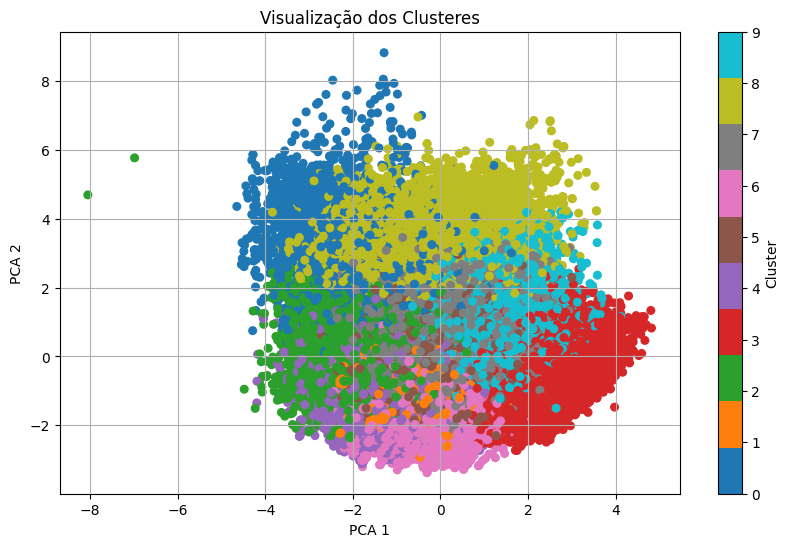

In [10]:
#Visualização com PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

labels = kmeans.labels_

#Reduzir para 2D
pca = PCA(n_components=2)
vetores_2d = pca.fit_transform(vetores_completos)

#Plotando os cluster
plt.figure(figsize=(10, 6))
plt.scatter(vetores_2d[:, 0],
            vetores_2d[:, 1], c=labels, cmap='tab10', s=30)
plt.title("Visualização dos Clusteres")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [11]:
df['cluster'] = labels

for cluster_id in sorted(df['cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    print(df[df['cluster'] == cluster_id]['NARRATIVA'].head(20).to_string(index=False))
    


--- Cluster 0 ---
COMPARECEU NESTA  CENTRAL DE OCORRÊNCIAS POLICI...
COMPARECEU NESTA DELPOL,RELATAR QUE E PROPRIETÁ...
NARRA A COMUNICANTE/VITIMA QUE EXTRAVIOU O SEU ...
NO MOMENTO QUE SAI DO HOSPITAL ESTAVA AGUARDAND...
COMPREI UM UNIFORME ESCOLAR NA INOVE, LOGO DEPO...
COMPARECEU A ESTA UNIDADE POLICIAL A VITIMA REL...
NARRA O COMUNICANTE O EXTRAVIO DAS SEGUINTES AN...
 COMPARECEU A COMUNICANTE, DIZENDO QUE EXTRAVIO...
PERCA DA PLACA RRO8J63 DA MOTOCICLETA YAMAHA FA...
ESTAVA FAZENDO EXAME EU PERDI MEU RG NA UNIDADE...
INFORMA O COMUNICANTE QUE REGISTROU O BOLETIM D...
NOTEI NA DATA DE HOJE QUE MEU VEICULO PLACA OAP...
QUE NO DIA 30 DE JANEIRO DE 2024, POR VOLTA DAS...
COMPARECEU NESTA UNIDADE POLICIAL A COMUNICANTE...
NA FACULDADE DE AGRONOMIA, MEUS PERTENCES QUE E...
INFORMA A COMUNICANTE QUE CONDUZIA SEU VEICULO ...
COMPARECEU O COMUNICANTE NESTA DELEGACIA DE POL...
NARRA A VÍTIMA/COMUNICANTE QUE CONTRATOU OS SER...
INFORMA A COMUNICANTE QUE É FILIADA AO CONCELHO...
EU ESTAVA DE